In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

cp.cuda.Device(0).use()


<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)
binning=0
pn = 256  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing
ne = 512
center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles
ndist = 4
# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
print(voxelsize)


7.999668874172185e-08


## Read real and imaginary parts of the refractive index u = delta+i beta

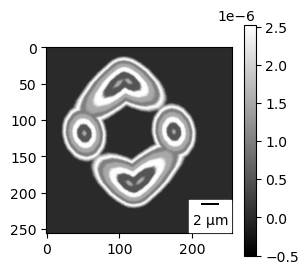

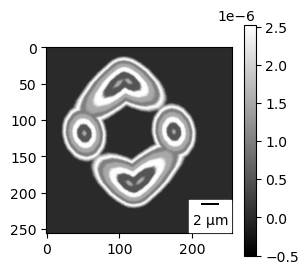

In [3]:
from cupyx.scipy import ndimage

cube_all = cp.zeros([n,n,n],dtype='float32')
rr = (cp.ones(8)*n*0.34).astype(cp.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = [30, 28, 25, 21, 16,10,3]#, 6, 3,1]
for kk in range(len(amps)):
    cube = cp.zeros([n,n,n],dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = cp.meshgrid(cp.arange(-n//2,n//2),cp.arange(-n//2,n//2),cp.arange(-n//2,n//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(circ)))
    fcube = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(cube.astype('float32'))))
    cube = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=3)
cube_all[cube_all<0] = 0



u0 = (-1*cube_all*1e-6+1j*cube_all*1e-8)/2
u0=np.roll(u0,-15,axis=2)
u0=np.roll(u0,-10,axis=1)
v = cp.arange(-n//2,n//2)/n
[vx,vy,vz] = cp.meshgrid(v,v,v)
v = cp.exp(-10*(vx**2+vy**2+vz**2))
fu = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(u0)))
u0 = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fu*v))).astype('complex64')

u = u0.astype('complex64').get()

fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=-0.5e-6)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.savefig('figs/deltahnoise.png',dpi=300,bbox_inches='tight')
plt.show()
# # sss

fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=-0.5e-6)
plt.colorbar()
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.savefig('figs/deltah_rotnoise.png',dpi=300,bbox_inches='tight')
plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(u0[n//2].imag.get(),cmap='gray')
# plt.colorbar()
# plt.savefig('figs/betah_rotnoise.png',dpi=300,bbox_inches='tight')
# plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(-u0[:,n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=-0.5e-6)
# plt.colorbar()
# plt.savefig('figs/deltav_rotnoise.png',dpi=300,bbox_inches='tight')
# plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(u0[:,n//2].imag.get(),cmap='gray')
# plt.colorbar()
# plt.savefig('figs/betav_rotnoise.png',dpi=300,bbox_inches='tight')
# plt.show()



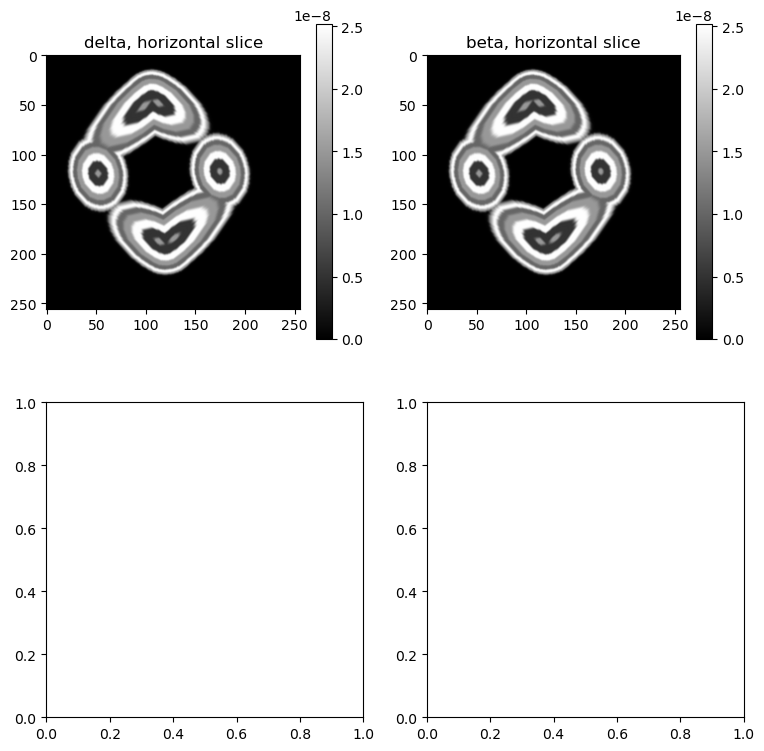

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u0[n//2].imag.get(),cmap='gray')
axs[0,0].set_title('delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(u[n//2].imag,cmap='gray')
axs[0,1].set_title('beta, horizontal slice')
fig.colorbar(im)
# im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
# axs[1,0].set_title('delta, vertical slice')
# fig.colorbar(im)
# im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
# axs[1,1].set_title('beta, vertical slice')
# fig.colorbar(im)
dxchange.write_tiff_stack(cube_all.astype('float32').get(),'/data/vnikitin/modeling/3d_ald_syn/cube.tiffnoise',overwrite=True)
dxchange.write_tiff(np.real(u).astype('float32'),'/data/vnikitin/modeling/3d_ald_syn/delta.tiffnoise',overwrite=True)

Note that in this formation delta is negative

## Create a solver class for tomography, use double sizes

In [5]:
tslv = holotomo.SolverTomo(theta, ntheta, n, n, pn, center)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [6]:

pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=True) 

512


note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

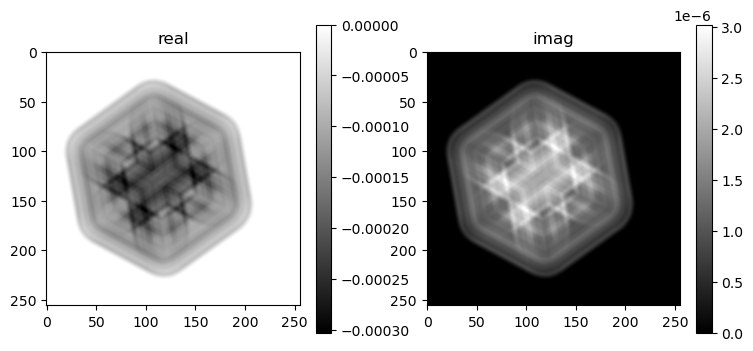

In [7]:
Ru = tslv.fwd_tomo_batch(u)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('real')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[0]),cmap='gray')
axs[1].set_title('imag')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [8]:
psi0 = pslv.exptomo(Ru)

-2.0919843
-2.5269783e-06


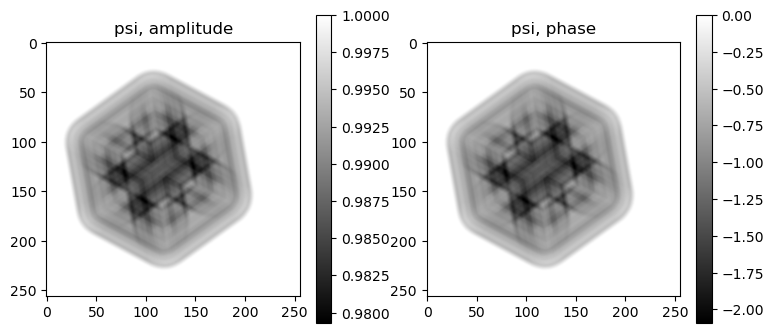

interactive(children=(IntSlider(value=0, description='sid', max=179), Output()), _dom_classes=('widget-interac…

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0[0]),cmap='gray')
axs[0].set_title('psi, amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0[0]),cmap='gray')
axs[1].set_title('psi, phase')
fig.colorbar(im)
print(np.amin(np.angle(psi0[0])))
print(np.amin(u.real))

from ipywidgets import interact
import ipywidgets as widgets
def plot_projections(sid=1):
    plt.imshow(np.angle(psi0[sid]),cmap='gray')
    plt.colorbar()
interact(plot_projections, sid = widgets.IntSlider(value=0,
                                            min=0,
                                            max=psi0.shape[0]-1,
                                                step=1))
dxchange.write_tiff(np.angle(psi0[0]).astype('float32'),'/data/vnikitin/modeling/3d_ald_syn/psiangle.tiffnoise',overwrite=True)


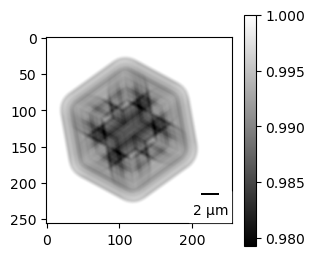

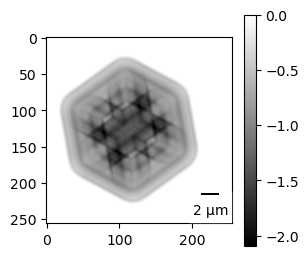

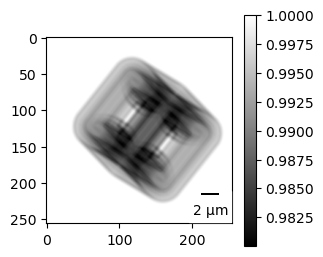

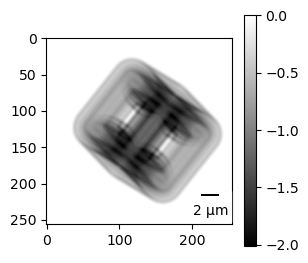

In [10]:
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.abs(psi0[0//2]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psi_absnoise.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.angle(psi0[0//2]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psi_anglenoise.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.abs(psi0[ntheta//2]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psi90_absnoise.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.angle(psi0[ntheta//2]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/psi90_anglenoise.png',dpi=300,bbox_inches='tight')

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

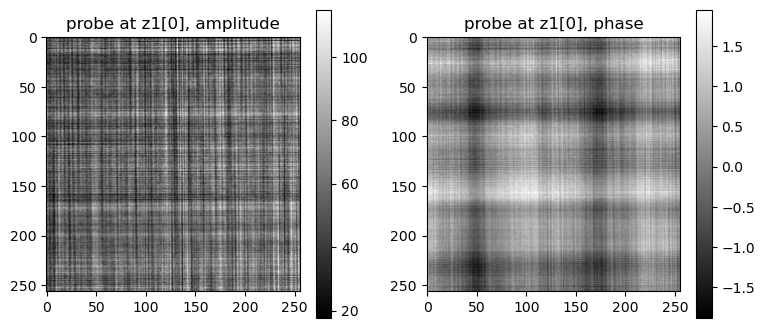

In [11]:
import scipy.ndimage as ndimage
prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_{2048}.tiff')[0:ndist]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_{2048}.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
prb[:] = prb[0]



for k in range(2):
    prb = prb[:,::2]+prb[:,1::2]
    prb = prb[:,:,::2]+prb[:,:,1::2]/4
# prb = ndimage.rotate(prb,20,axes=(1,2),reshape=False)

prb = prb[:,128:-128,128:-128]
# for k in range(ndist):
#     prb_abs = dxchange.read_tiff(f'../3d_ald_syn/data/prb_syn_abs_{n}_{k}.tiff')
#     prb_phase = dxchange.read_tiff(f'../3d_ald_syn/data/prb_syn_angle_{n}_{k}.tiff')
#     prb[k] = prb_abs*np.exp(1j*prb_phase).astype('complex64')      
# prb[:] = prb[0]    


# v = np.arange(-n//2,n//2)/n
# [vx,vy] = np.meshgrid(v,v)
# v = np.exp(-15*(vx**2+vy**2))
# fu = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(prb)))
# prb = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(fu*v))).astype('complex64')


fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('probe at z1[0], phase')
fig.colorbar(im)

In [12]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]

# Compute holographic projections for all angles and all distances

In [13]:
psi = np.pad(psi0,((0,0),((ne-n)//2,(ne-n)//2),((ne-n)//2,(ne-n)//2)),'edge')
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
print(psi.shape)
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref)
fref = pslv.fwd_holo_batch(psi*0+1,prb,shifts_ref*0) # ignore sample
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref) # ignore probe

(180, 512, 512)


## Take squared absolute value to simulate data on the detector, ref fields, and data with homogeneous ref fields  

In [14]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
data0 = np.abs(fpsi0)**2
#data+=np.random.normal(0,100,(data.shape))
data =np.random.poisson(data/20)*20
data[data<0]=0
#ref+=np.random.normal(0,100,(ref.shape))
ref =np.random.poisson(ref/20)*20
ref[ref<0]=0
print()


# !!!Note that simple ref-field correction creates artifacts!!! Demonstration:

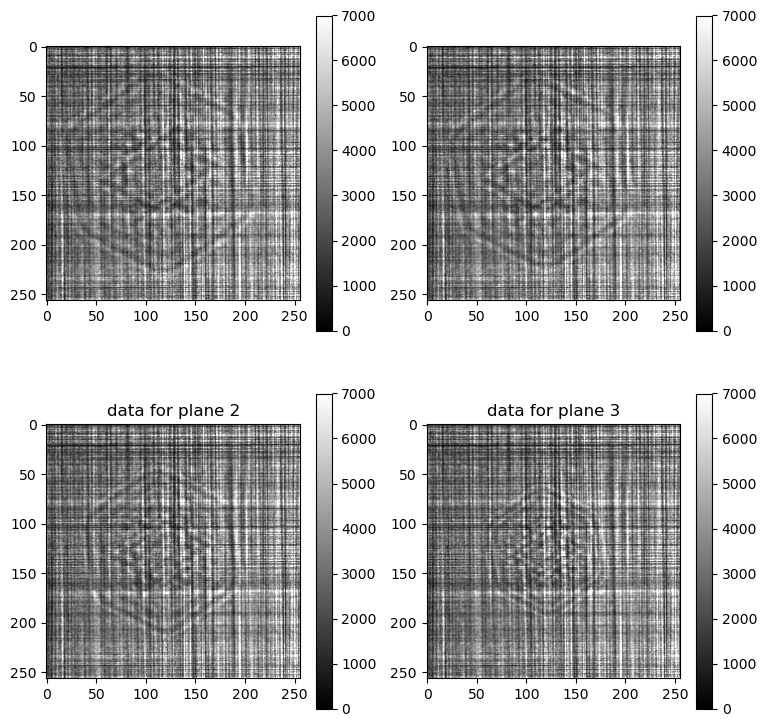

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray',vmin=0,vmax=7000)
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray',vmin=0,vmax=7000)
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray',vmin=0,vmax=7000)
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0],cmap='gray',vmin=0,vmax=7000)
axs[1,1].set_title('data for plane 3')

fig.colorbar(im)

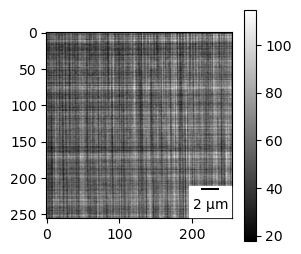

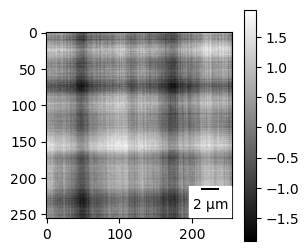

In [23]:
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.abs(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/prb_absnoise.png',dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(np.angle(prb[0]),cmap='gray')
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar()
plt.savefig('figs/prb_anglenoise.png',dpi=300,bbox_inches='tight')

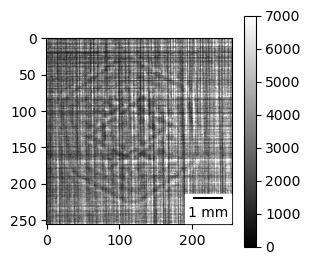

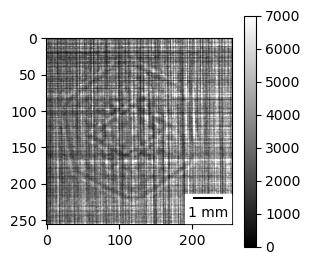

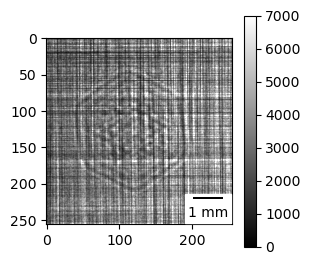

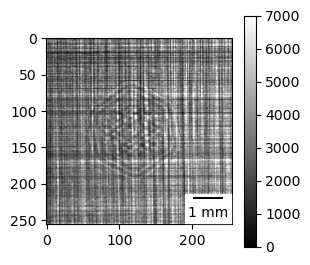

In [17]:
for k in range(4):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(np.abs(data[k,0]),cmap='gray',vmin=0,vmax=7000)
    ax.add_artist(ScaleBar(voxelsize*magnifications[0],location='lower right'))
    plt.colorbar()
    plt.savefig(f'figs/data{k}noise.png',dpi=300,bbox_inches='tight')

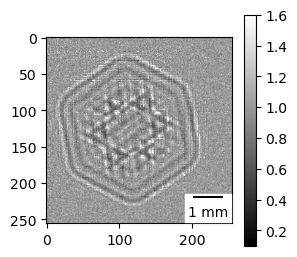

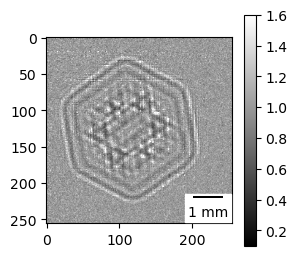

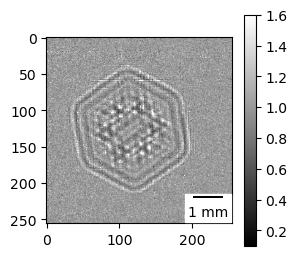

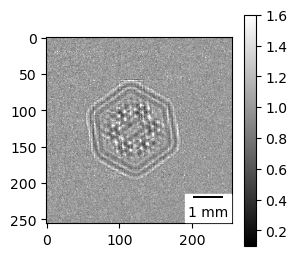

In [18]:

for k in range(4):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(data[k,0]/(ref[0,0]+1e-7),cmap='gray',vmin=0.1,vmax=1.6)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize*magnifications[0],location='lower right'))
    plt.savefig(f'figs/rdata{k}noise.png',dpi=300,bbox_inches='tight')

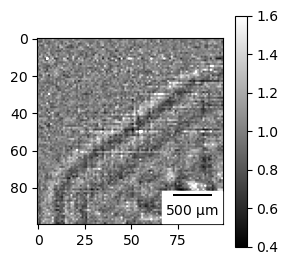

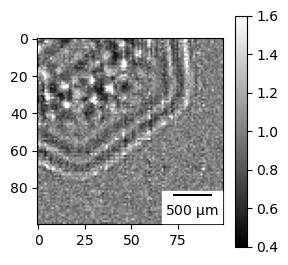

In [19]:
stx = 10
sty = 10
lenx = 100
leny = 100
for k in range(1):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(data[k,0,sty:sty+leny,stx:stx+lenx]/ref[0,0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=0.4,vmax=1.6)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize*magnifications[0],location='lower right',length_fraction=.25))
    plt.savefig(f'figs/rsdata{k}noise.png',dpi=300,bbox_inches='tight')
stx = 100
sty = 120
lenx = 100
leny = 100
for k in range(3,4):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    plt.imshow(data[k,0,sty:sty+leny,stx:stx+lenx]/ref[0,0,sty:sty+leny,stx:stx+lenx],cmap='gray',vmin=0.4,vmax=1.6)
    plt.colorbar()
    ax.add_artist(ScaleBar(voxelsize*magnifications[0],location='lower right',length_fraction=.25))
    plt.savefig(f'figs/rsdata{k}noise.png',dpi=300,bbox_inches='tight')

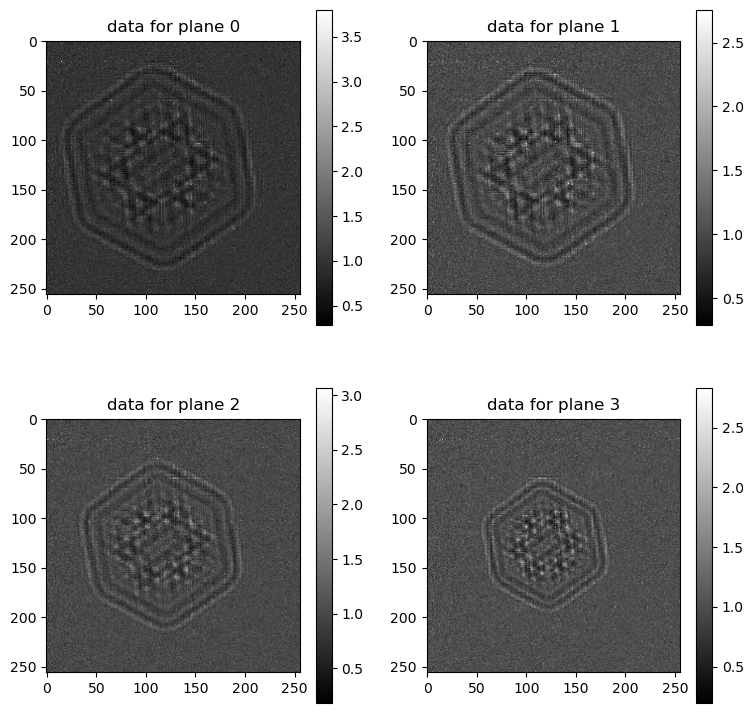

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0]/ref[0,0],cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0]/ref[0,0],cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0]/ref[0,0],cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0]/ref[0,0],cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)


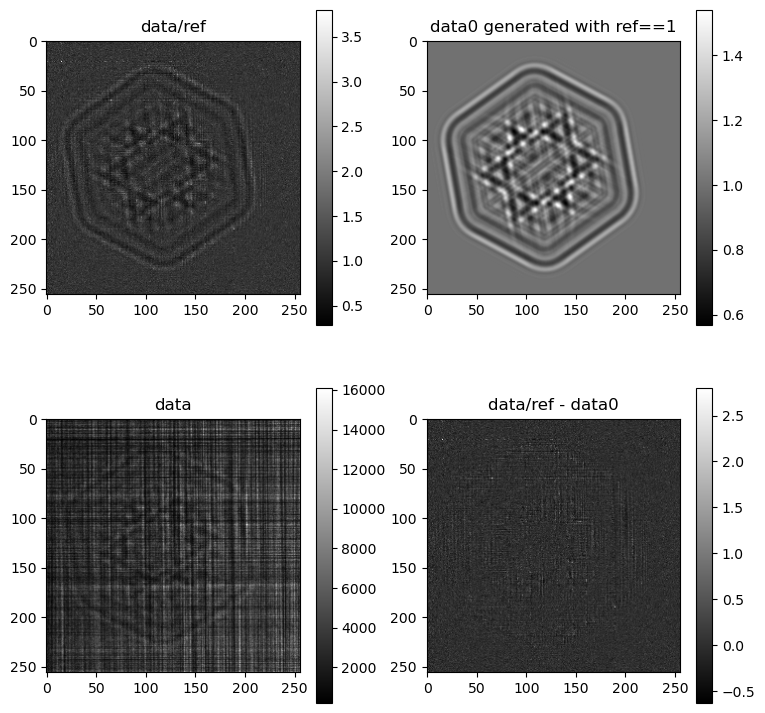

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0]/ref[0,0],cmap='gray')
axs[0,0].set_title('data/ref')
fig.colorbar(im)
im=axs[0,1].imshow(data0[0,0],cmap='gray')
axs[0,1].set_title('data0 generated with ref==1')
fig.colorbar(im)
im=axs[1,0].imshow(data[0,0],cmap='gray')
axs[1,0].set_title('data')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,0]/ref[0,0]-data0[0,0],cmap='gray')
axs[1,1].set_title('data/ref - data0')
fig.colorbar(im)

# Save data nd ref fields

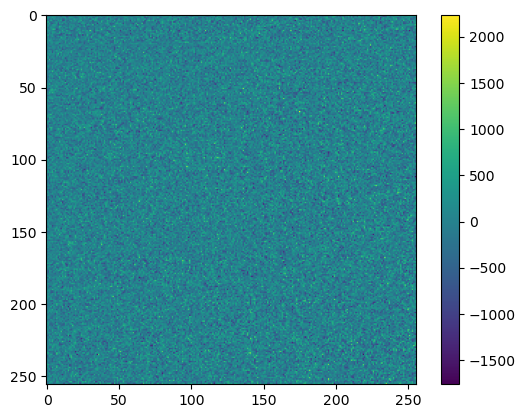

In [22]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_3d_ald_syn_{n}_{k}noise',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[k,0],f'data/modeling/ref_3d_ald_syn_{n}_{k}noise',overwrite=True)
dxchange.write_tiff(np.abs(psi),f'data/modeling/psi_abs_3d_ald_syn_{n}noise',overwrite=True)
dxchange.write_tiff(np.angle(psi),f'data/modeling/psi_angle_3d_ald_syn_{n}noise',overwrite=True)
np.save('shifts',shifts)
plt.imshow(ref[0,0]-ref[1,0])
plt.colorbar()
plt.show()